# Exploratory Data Analysis for Amazon Product Recommender

## Capstone-1 by Dr. Uma Gajendragadkar

In [1]:
import os
import pandas as pd
import math
import gzip
import numpy as np
import scipy.stats as stats
from scipy.sparse import csc_matrix, csr_matrix
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
#import seaborn as sns; sns.set(style="white", color_codes=True)

import operator
import re
from collections import OrderedDict
import seaborn as sns
import pickle
import os.path
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import matplotlib.cm as cmx

from pylab import rcParams
#from mpl_toolkits.basemap import Basemap
#from geopy.geocoders import Nominatim

import warnings 
%matplotlib inline
warnings.filterwarnings("ignore")
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [21]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
 
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)
# Adapted from http://spartanideas.msu.edu/2014/06/28/how-to-make-beautiful-data-visualizations-in-python-with-matplotlib/
cmap_set1 = ListedColormap(['#4daf4a', '#377eb8', '#e41a1c' ])

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
sns.set_style('ticks')

In [2]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

video_data = getDF('reviews_Amazon_Instant_Video_5.json.gz')
automotive_data = getDF('reviews_Automotive_5.json.gz')
musical_data = getDF('reviews_Musical_Instruments_5.json.gz')
office_data = getDF('reviews_Office_Products_5.json.gz')
patio_data = getDF('reviews_Patio_Lawn_and_Garden_5.json.gz')

df = getDF('reviews_Patio_Lawn_and_Garden_5.json.gz')
patio_meta = getDF('meta_Patio_Lawn_and_Garden.json.gz')

video_meta = getDF('meta_Amazon_Instant_Video.json.gz')
automotive_meta = getDF('meta_Automotive.json.gz')
musical_meta = getDF('meta_Musical_Instruments.json.gz')
office_meta = getDF('meta_Office_Products.json.gz')

In [3]:
patio_meta.head()

,asin,description,title,imUrl,related,salesRank,categories,price,brand
0,0981850006,Steven Raichlen's Best of Barbecue Primal Gril...,"Primal Grill with Steven Raichlen, Volume One",http://ecx.images-amazon.com/images/I/51cNn5Dl...,"{'also_viewed': ['0761149430', '0761120149', '...",{'Movies & TV': 231134},"[[Patio, Lawn & Garden, Grills & Outdoor Cooki...",NaN,NaN
1,144072007X,The Tesoro Sand Shark metal combines time-prov...,Sand Shark Margare Maron Audio CD,http://ecx.images-amazon.com/images/I/31B9X0S6...,"{'also_viewed': ['B008WC0X0A', 'B000CPMOVG', '...","{'Patio, Lawn & Garden': 188289}","[[Patio, Lawn & Garden, Lawn Mowers & Outdoor ...",577.15,Tesoro
2,1554701503,This definitive guide to incorporating planks ...,Napoleon's Everyday Plank Grilling,http://ecx.images-amazon.com/images/I/51cTWw9d...,"{'also_bought': ['B0036Y9CH4', '1554702615', '...","{'Patio, Lawn & Garden': 196610}","[[Patio, Lawn & Garden, Grills & Outdoor Cooki...",26.39,Napoleon
3,1579822932,This is a Bad Kitty backpack pull clip.,Bad Kitty Backpack Pull,http://ecx.images-amazon.com/images/I/41nR62o%...,"{'also_bought': ['1596438444', '1596436700', '...",{'Toys & Games': 183251},"[[Patio, Lawn & Garden, Picnic Baskets & Acces...",3.65,Bad Kitty
4,1754164498,Every spa needs to be shocked to eliminate und...,5 pound SpaGuard Enhanced Spa Shock,http://ecx.images-amazon.com/images/I/21cOwSPt...,"{'also_bought': ['B00AJZO9MQ', 'B006MHSEVW', '...","{'Patio, Lawn & Garden': 80211}","[[Patio, Lawn & Garden, Pools, Hot Tubs & Supp...",29.99,SpaGuard


In [4]:
patio_data['unixReviewTime'] = pd.to_datetime(patio_data['unixReviewTime'],unit='s') #changing time format
#df.rename(columns={'unixReviewTime': 'ReviewTime', 'asin': 'product'}, inplace=True)
#df = df.drop('reviewTime',1)
patio_data.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1JZFGZEZVWQPY,B00002N674,"Carter H ""1amazonreviewer@gmail . com""","[4, 4]",Good USA company that stands behind their prod...,4.0,Great Hoses,2011-06-21,"06 21, 2011"
1,A32JCI4AK2JTTG,B00002N674,"Darryl Bennett ""Fuzzy342""","[0, 0]",This is a high quality 8 ply hose. I have had ...,5.0,Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,2014-06-09,"06 9, 2014"
2,A3N0P5AAMP6XD2,B00002N674,H B,"[2, 3]",It's probably one of the best hoses I've ever ...,4.0,Very satisfied!,2012-05-05,"05 5, 2012"
3,A2QK7UNJ857YG,B00002N674,Jason,"[0, 0]",I probably should have bought something a bit ...,5.0,Very high quality,2013-07-15,"07 15, 2013"
4,AS0CYBAN6EM06,B00002N674,jimmy,"[1, 1]",I bought three of these 5/8-inch Flexogen hose...,5.0,Good Hoses,2013-08-05,"08 5, 2013"


Dataframe patio_data created from 'reviews_Patio_Lawn_and_Garden_5.json.gz' file contains data for attributes { reviewrID - userid, asin - productid, reviewerName, heplful - how helpful review is, reviewText, overall - rating given for a product, summary, unixReviewTime and ReviewTime} 
Dataframe patio_meta created from 'meta_Patio_Lawn_and_Garden.json.gz' file contains data for attributes {asin - prodcutid, description- product description, title -Title of prodcut, imUrl - image url of product, related - list of also viewed products , salesRank, categories- list of categories to which product belongs, price- price of prodcut, brand- brandname to which product belongs}
As I am going to build a recommender system based on Ratings given to prodcuts, I have to create subset of data by merging both dataframes and choose required attributes only.

In [5]:
# merging two dataframes to create new subset of required data
finaldf = pd.merge(patio_data, patio_meta[['asin','title', 'categories', 'price']], on='asin', how='left')


In [6]:
#Data cleaning - dropping the rows with NAN 
finaldf = finaldf.dropna(how = 'any')
video_data = video_data.dropna(how= 'any')
automotive_data = automotive_data.dropna(how= 'any')
musical_data = musical_data.dropna(how= 'any')
office_data = office_data.dropna(how= 'any')


In [7]:
finaldf.shape

(12732, 12)

Dataset comprises of 12732 observations and 12 attributes.

It is also a good practice to know the columns and their corresponding data types,along with finding whether they contain null values or not.

In [9]:
finaldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12732 entries, 0 to 13271
Data columns (total 12 columns):
reviewerID        12732 non-null object
asin              12732 non-null object
reviewerName      12732 non-null object
helpful           12732 non-null object
reviewText        12732 non-null object
overall           12732 non-null float64
summary           12732 non-null object
unixReviewTime    12732 non-null datetime64[ns]
reviewTime        12732 non-null object
title             12732 non-null object
categories        12732 non-null object
price             12732 non-null float64
dtypes: datetime64[ns](1), float64(2), object(9)
memory usage: 1.3+ MB


Data has 2 float columns, 1 dateTime and 9 object type columns. No variable column has null/missing values.

In [10]:
finaldf.describe()

,overall,price
count,12732.000000,12732.000000
mean,4.187402,44.457910
std,1.082086,73.404245
min,1.000000,0.500000
25%,4.000000,10.670000
50%,5.000000,19.650000
75%,5.000000,39.900000
max,5.000000,819.000000


In [11]:
finaldf.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,title,categories,price
0,A1JZFGZEZVWQPY,B00002N674,"Carter H ""1amazonreviewer@gmail . com""","[4, 4]",Good USA company that stands behind their prod...,4.0,Great Hoses,2011-06-21,"06 21, 2011",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,"[[Patio, Lawn & Garden, Gardening & Lawn Care,...",29.53
1,A32JCI4AK2JTTG,B00002N674,"Darryl Bennett ""Fuzzy342""","[0, 0]",This is a high quality 8 ply hose. I have had ...,5.0,Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,2014-06-09,"06 9, 2014",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,"[[Patio, Lawn & Garden, Gardening & Lawn Care,...",29.53
2,A3N0P5AAMP6XD2,B00002N674,H B,"[2, 3]",It's probably one of the best hoses I've ever ...,4.0,Very satisfied!,2012-05-05,"05 5, 2012",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,"[[Patio, Lawn & Garden, Gardening & Lawn Care,...",29.53
3,A2QK7UNJ857YG,B00002N674,Jason,"[0, 0]",I probably should have bought something a bit ...,5.0,Very high quality,2013-07-15,"07 15, 2013",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,"[[Patio, Lawn & Garden, Gardening & Lawn Care,...",29.53
4,AS0CYBAN6EM06,B00002N674,jimmy,"[1, 1]",I bought three of these 5/8-inch Flexogen hose...,5.0,Good Hoses,2013-08-05,"08 5, 2013",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,"[[Patio, Lawn & Garden, Gardening & Lawn Care,...",29.53


In [12]:

finaldf.rename(columns={'asin': 'product'}, inplace=True)
finaldf = finaldf.drop('unixReviewTime',1)

In [13]:
number_of_unique_products = len(finaldf['product'].unique())
number_of_unique_users = len(finaldf['reviewerID'].unique())
number_of_ratings = len(finaldf)
print ("Number of unique products =", number_of_unique_products)
print ("Number of unique users =", number_of_unique_users)
print ("Number of ratings =", number_of_ratings)

Number of unique products = 919
Number of unique users = 1685
Number of ratings = 12732


In [14]:
finaldf = finaldf.drop(['reviewText','reviewerName','summary'],1)

We currently don't need {reviewText','reviewerName','summary'} columns so we delete those.

In [15]:
finaldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12732 entries, 0 to 13271
Data columns (total 8 columns):
reviewerID    12732 non-null object
product       12732 non-null object
helpful       12732 non-null object
overall       12732 non-null float64
reviewTime    12732 non-null object
title         12732 non-null object
categories    12732 non-null object
price         12732 non-null float64
dtypes: float64(2), object(6)
memory usage: 895.2+ KB


In [16]:
finaldf.overall.value_counts()

5.0    6746
4.0    3255
3.0    1597
2.0     639
1.0     495
Name: overall, dtype: int64

This tells us vote count of each overall{Rating} score in descending order. “overall” has most values concentrated in the categories 5,4 and 3. Ratings 1 and 2 have less number of observations.

In [17]:
dftemp = pd.DataFrame(finaldf.groupby(['overall']).count()['product'].reset_index())

In [18]:
dftemp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
overall    5 non-null float64
product    5 non-null int64
dtypes: float64(1), int64(1)
memory usage: 160.0 bytes


In [19]:
dftemp.head()

,overall,product
0,1.0,495
1,2.0,639
2,3.0,1597
3,4.0,3255
4,5.0,6746


Text(0.5, 1.0, 'Distribution of overall rating for Amazon Products')

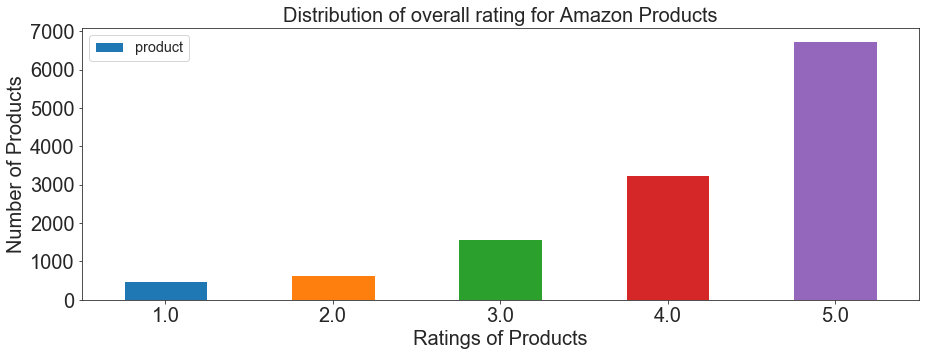

In [23]:
plt.figsize=(15, 4)
ax = dftemp.plot.bar(x='overall', y='product', rot=0, fontsize=20)
ax.set_xlabel('Ratings of Products',fontsize=20)
ax.set_ylabel('Number of Products',fontsize=20)
ax.set_title('Distribution of overall rating for Amazon Products', fontsize=20)

Above plot shows that many users have given 5 rating to prodcuts followed by 4 and 3 whereas very few users have given a low rating of 1 or 2.

In [42]:
dftemp = (finaldf.groupby(['overall']).count()['product'])

For finding year wise trend in the data, we need to insert a new column named year derived from reviewTime. Similarly we can add 'month' column derived from reviewTime.

In [43]:
import datetime as dt
finaldf['year']=pd.to_datetime(finaldf['reviewTime'], format='%m %d, %Y').dt.year
finaldf['month']=pd.to_datetime(finaldf['reviewTime'], format='%m %d, %Y').dt.month

In [44]:
finaldf.head()

,reviewerID,product,helpful,overall,reviewTime,title,categories,price,year,month
0,A1JZFGZEZVWQPY,B00002N674,"[4, 4]",4.0,"06 21, 2011",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,"[[Patio, Lawn & Garden, Gardening & Lawn Care,...",29.53,2011,6
1,A32JCI4AK2JTTG,B00002N674,"[0, 0]",5.0,"06 9, 2014",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,"[[Patio, Lawn & Garden, Gardening & Lawn Care,...",29.53,2014,6
2,A3N0P5AAMP6XD2,B00002N674,"[2, 3]",4.0,"05 5, 2012",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,"[[Patio, Lawn & Garden, Gardening & Lawn Care,...",29.53,2012,5
3,A2QK7UNJ857YG,B00002N674,"[0, 0]",5.0,"07 15, 2013",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,"[[Patio, Lawn & Garden, Gardening & Lawn Care,...",29.53,2013,7
4,AS0CYBAN6EM06,B00002N674,"[1, 1]",5.0,"08 5, 2013",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,"[[Patio, Lawn & Garden, Gardening & Lawn Care,...",29.53,2013,8


In [155]:
df_by_year = finaldf.groupby(['year'])
df_by_month = finaldf.groupby(['year','month'])

In [46]:
list(df_by_year)[2]

(2002,          reviewerID     product   helpful  overall   reviewTime  \
 64   A20CQ20J30DJZT  B00004DTNH  [12, 14]      5.0  06 23, 2002   
 607   AVBLGXSWRN666  B00004U9VV  [13, 15]      5.0  12 14, 2002   
 614  A20CQ20J30DJZT  B00004U9VV    [3, 3]      5.0  11 30, 2002   
 687  A3V6Z4RCDGRC44  B00004ZAW4  [50, 51]      5.0  09 20, 2002   
 
                                                  title  \
 64   Black &amp; Decker LE750 Edge Hog 2-1/4 HP Ele...   
 607  Weber 87886 Chimney Starter (Discontinued by M...   
 614  Weber 87886 Chimney Starter (Discontinued by M...   
 687  Garden Song 455-3 Window Mounted 14-Ounce Glas...   
 
                                             categories  price  year  month  
 64   [[Patio, Lawn & Garden, Roll into Spring, Blac...  64.99  2002      6  
 607  [[Patio, Lawn & Garden, Grills & Outdoor Cooki...  14.99  2002     12  
 614  [[Patio, Lawn & Garden, Grills & Outdoor Cooki...  14.99  2002     11  
 687  [[Patio, Lawn & Garden, Perky-Pet, Hu

In [47]:
df_p = df_by_year.mean()

In [49]:
df_p = df_p.reset_index()

In [50]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 4 columns):
year       15 non-null int64
overall    15 non-null float64
price      15 non-null float64
month      15 non-null float64
dtypes: float64(3), int64(1)
memory usage: 560.0 bytes


Plotting average rating of the products over the years -->>

Text(0.5, 1.0, 'Mean Rating of Amazon Products over years')

<Figure size 1080x288 with 0 Axes>

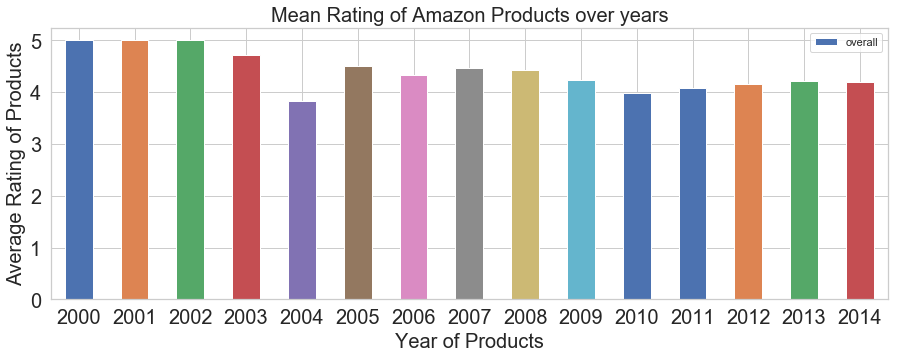

In [136]:
plt.figure(figsize=(15, 4))
ax =  df_p.plot.bar(x='year', y= 'overall', rot=0, fontsize=20)
ax.set_xlabel('Year of Products', fontsize=20)
ax.set_ylabel('Average Rating of Products', fontsize=20)
ax.set_title('Mean Rating of Amazon Products over years',fontsize=20) 

In [ ]:
Looking at above plot, we can infer that over the years from 2000 to 2014, the mean rating of the products has reduced.

In [104]:
# Get median values by year and print first 5 rows
df_med_by_year = df_by_year.median()
df_med_by_year.head()

,overall,price,month
year,,,
2000,5.0,49.990,5.0
2001,5.0,13.605,4.0
2002,5.0,14.990,10.0
2003,5.0,49.640,6.0
2004,5.0,142.495,7.5


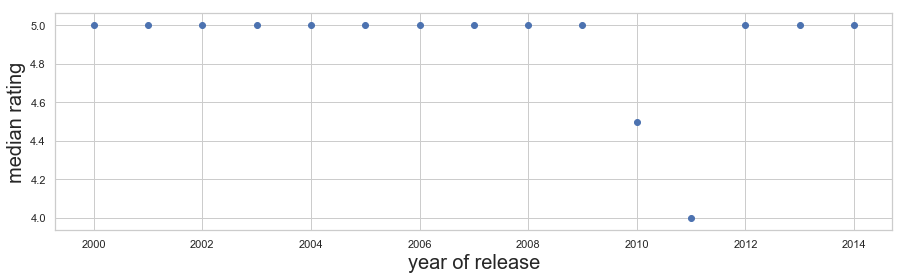

In [132]:
plt.figure(figsize=(15, 4))
df_rat_by_year = df_med_by_year['overall']
plt.scatter(df_rat_by_year.index, df_rat_by_year)
plt.xlabel('year of release', fontsize=20)
plt.ylabel('median rating', fontsize=20);

Median of ratings given to products remain at 5 from 2000 to 2014 except for years 2010 and 2011

In [107]:
#Trend on ratings given by Year 
# Plot  a graph of year vs. No.of Ratings of products
df2 = pd.DataFrame(finaldf.groupby('year').agg('sum')['overall'])
df2 = df2.reset_index()
df2.info()
df2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
year       15 non-null int64
overall    15 non-null float64
dtypes: float64(1), int64(1)
memory usage: 320.0 bytes


,year,overall
0,2000,15.0
1,2001,10.0
2,2002,20.0
3,2003,33.0
4,2004,23.0


Text(0.5, 1.0, 'Trend on Ratings by Year')

<Figure size 1080x288 with 0 Axes>

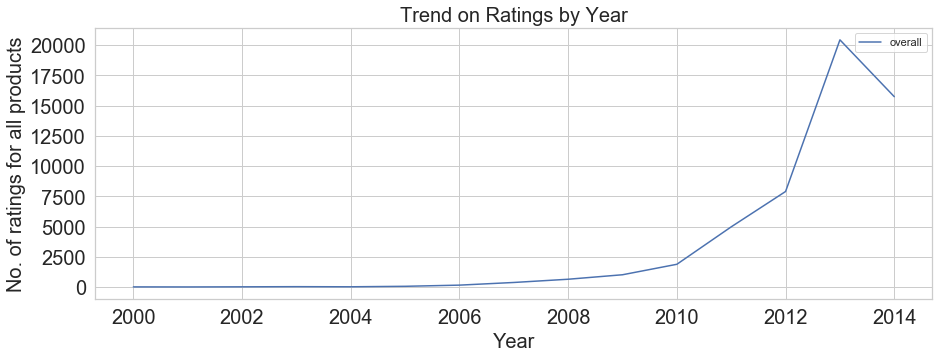

In [130]:
plt.figure(figsize=(15, 4))
ax = df2.plot.line(x='year', y ='overall', fontsize=20)
ax.set_xlabel('Year', fontsize= 20)
ax.set_ylabel('No. of ratings for all products', fontsize=20)
ax.set_title('Trend on Ratings by Year', fontsize=20)

There is an increasing trend for number of ratings given by the users to products on Amazon which indicates that more number of users started using Amazon ecommerce site for online shopping and more number of users started giving feedback on the products purchased from 2000 to 2014. There is a significant increase in number of ratings given by users from 2012 to 2014.

In [145]:
# Trend - Rating breakdown for products by year
df3 = pd.DataFrame(finaldf.groupby(['overall','year']).count()['product'])
df3 = df3.reset_index()
df3.info()
df3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 3 columns):
overall    55 non-null float64
year       55 non-null int64
product    55 non-null int64
dtypes: float64(1), int64(2)
memory usage: 1.4 KB


,overall,year,product
0,1.0,2004,1
1,1.0,2006,1
2,1.0,2007,4
3,1.0,2008,6
4,1.0,2009,15


In [146]:
df3.tail()

,overall,year,product
50,5.0,2010,236
51,5.0,2011,593
52,5.0,2012,991
53,5.0,2013,2596
54,5.0,2014,1978


Text(0.5, 1.0, 'Yearwise count of Amazon Products with particular Rating')

<Figure size 1080x288 with 0 Axes>

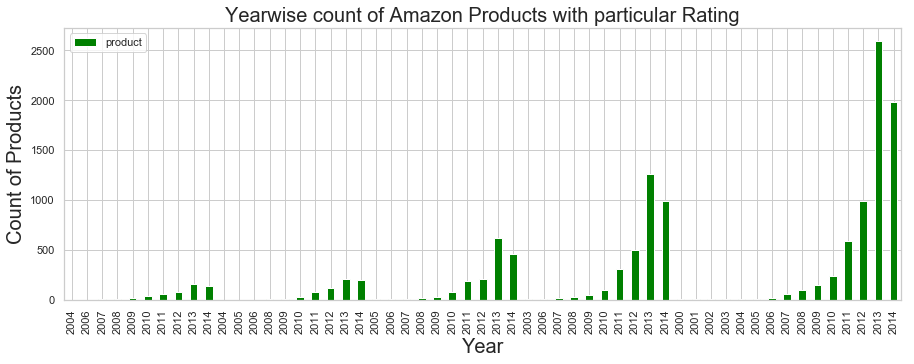

In [149]:
plt.figure(figsize=(15, 4))
ax1 = df3.plot.bar(x='year', y ='product', color='green')
ax1.set_xlabel('Year', fontsize=20)
ax1.set_ylabel('Count of Products', fontsize=20)
ax1.set_title('Yearwise count of Amazon Products with particular Rating', fontsize=20)

We can infer from above plot that 
1) Users do not give bad ratings unless there is some real reason as we can observe that number products with rating '1' or rating '2'also rating '3' is significantly less over the years as comapred to ratings '3' and '4'
2) From 2006 to 2013, there is increasing trend in total number of ratings, total number of good ratngs(4,5).
3) In 2013, there is a sudden surge of positive ratings and in 2014 it has decresed again.

In [156]:
#Trend on ratings given by month 
# Plot  a graph of year vs. No.of Ratings of products
df_m = pd.DataFrame(df_by_month.agg('sum')['overall'])
df_m = df_m.reset_index()
df_m.info()
df_m.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 3 columns):
year       122 non-null int64
month      122 non-null int64
overall    122 non-null float64
dtypes: float64(1), int64(2)
memory usage: 2.9 KB


,year,month,overall
0,2000,5,10.0
1,2000,7,5.0
2,2001,4,10.0
3,2002,6,5.0
4,2002,9,5.0


In [174]:
df_m['year'].value_counts()
df_m['year'].unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014], dtype=int64)

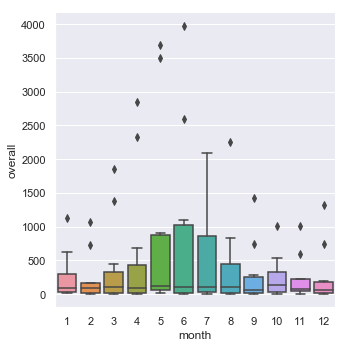

In [195]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
g= sns.catplot(x="month",y="overall",kind='box',data=df_m)


From the boxplot above, we can say that highest number of ratings are given in the month of May followed by May and July. It indiacates that in these three months, there is high volumes of purchases done by the users. As agianst that February shows the lowest number of ratings given by users so on can infer that lowest sales might have happened in the month of February. 

In [111]:
#Group by User and count number of ratings given and plot
df4 = pd.DataFrame(finaldf.groupby('reviewerID').count()['overall'].reset_index())
df4.head()

,reviewerID,overall
0,A100WO06OQR8BQ,63
1,A1047EDJ84IMAS,7
2,A106ZCP7RSXMRU,5
3,A10BGNHGWPN7ZE,13
4,A10H24TDLK2VDP,8


In [112]:
# Number of ratings given by user max = 63, min = 1 and mean = 7.55
print("Total number of users in Garden and Patio dataset:", df4['reviewerID'].count())
print("Maximum number of ratings given by user:", df4['overall'].max())
print("Average number of ratings by users:", df4['overall'].mean())
print("Minimum number of ratings by user:", df4['overall'].min())

Total number of users in Garden and Patio dataset: 1685
Maximum number of ratings given by user: 63
Average number of ratings by users: 7.5560830860534125
Minimum number of ratings by user: 1


Text(0.5, 1.0, 'Distribution of Ratings per User')

<Figure size 1080x288 with 0 Axes>

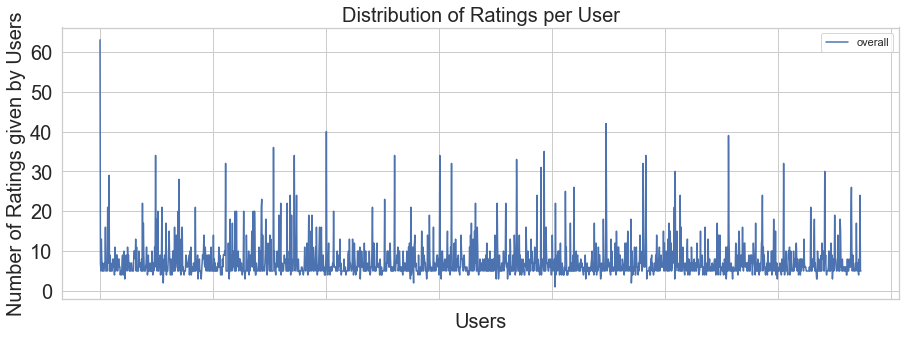

In [127]:
plt.figure(figsize=(15, 4))
bx = df4.plot(x= 'reviewerID', y = 'overall', fontsize=20)
bx.set_xlabel("Users", fontsize=20)
bx.set_ylabel("Number of Ratings given by Users", fontsize=20)
bx.set_title("Distribution of Ratings per User", fontsize=20)

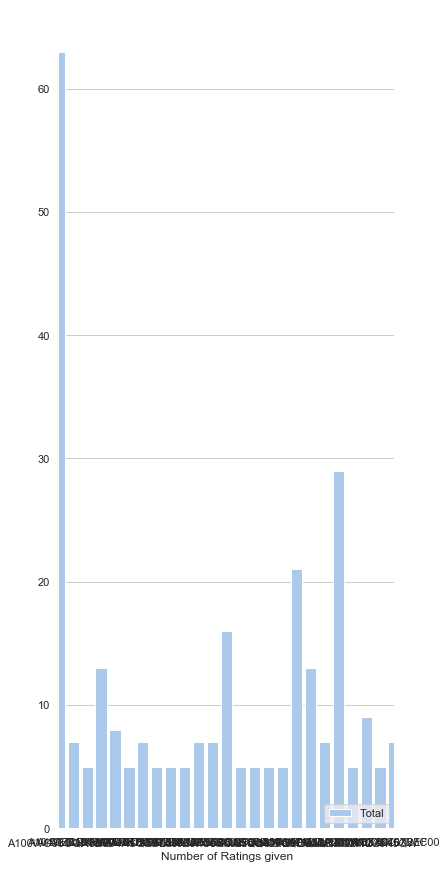

In [196]:
#Same plot of Number of Ratings given by each user in seaborn

sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Load the dataset
#rating = sns.load_dataset(df4).sort_values("overall", ascending=False)

# Plot the total ratings for each user
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_color_codes("pastel")
sns.barplot(x="reviewerID", y="overall", data=df4,
            label="Total", color="b")



# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="",
       xlabel="Number of Ratings given")
sns.despine(left=True, bottom=True)

Total number of users in Garden and Patio dataset is 1685.Maximum number of ratings given by  single user is 63 and minimum number of ratings by single user is 1. On an average a user gives 7.55 ratings on Amazon as per the data present ( till 2014)

Checking for correlation between attributes  in Garden and Patio dataset->>

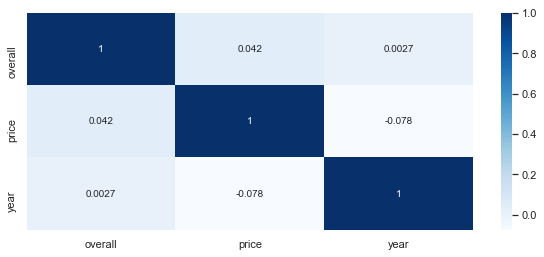

In [38]:
plt.figure(figsize=(10,4))
sns.heatmap(finaldf.corr(),cmap='Blues',annot=True) 

Dark shades represents positive correlation while lighter shades represents negative correlation. Here correlation for numerical columns of dataframe is plotted as other columns are object type.
If you set annot=True, you’ll get values by which features are correlated to each other in grid-cells.
Here we can say that year and overall (Rating) have somewaht positive corelation whereas overall (Rating) and price has a positive correlation.

In [208]:
df_video = video_data.groupby('overall').count()['asin'].reset_index()

In [209]:
df_video.head()

,overall,asin
0,1.0,1695
1,2.0,1873
2,3.0,4158
3,4.0,8383
4,5.0,20688


In [210]:
df_video = df_video.set_index('overall').T

df_video.head()
#df_video.plot(kind='bar', stacked =True)

overall,1.0,2.0,3.0,4.0,5.0
asin,1695,1873,4158,8383,20688


In [211]:
# finding number of products with each rating category [1,2,3,4,5]
df_video = video_data.groupby('overall').count()['asin'].reset_index()
df_musical = musical_data.groupby('overall').count()['asin'].reset_index()
df_office = office_data.groupby('overall').count()['asin'].reset_index()
df_automotive = automotive_data.groupby('overall').count()['asin'].reset_index()
df_patio = patio_data.groupby('overall').count()['asin'].reset_index()

In [212]:
#Plot of number of products with each rating by product category

x=df_video['overall']  #since the date are the same in both tables I only have 1 x
y1=df_video['asin']
y2=df_office['asin']
y3=df_musical['asin']
y4 = df_patio['asin']
y5 = df_automotive['asin']
df_new = pd.DataFrame()
df_new['overall'] = x
df_new['video'] = y1
df_new['office'] = y2
df_new['musical']= y3
df_new['patio'] = y4
df_new['automotive'] = y5
df_new.columns = ['Rating', 'Instant Video', 'Office', 'Musical Instruments', 'Patio Lawn & Garden', 'Automotive']
df_new.reset_index()
df_new.set_index('Rating')
df_new.head()

,Rating,Instant Video,Office,Musical Instruments,Patio Lawn & Garden,Automotive
0,1.0,1695,1126,216,519,536
1,2.0,1873,1716,249,673,597
2,3.0,4158,5030,771,1659,1413
3,4.0,8383,14893,2080,3384,3927
4,5.0,20688,30034,6918,7037,13787


In [213]:
df_new = df_new.set_index('Rating').transpose()
df_new

Rating,1.0,2.0,3.0,4.0,5.0
Instant Video,1695,1873,4158,8383,20688
Office,1126,1716,5030,14893,30034
Musical Instruments,216,249,771,2080,6918
Patio Lawn & Garden,519,673,1659,3384,7037
Automotive,536,597,1413,3927,13787


<Figure size 1080x1080 with 0 Axes>

<Figure size 842.4x595.44 with 0 Axes>

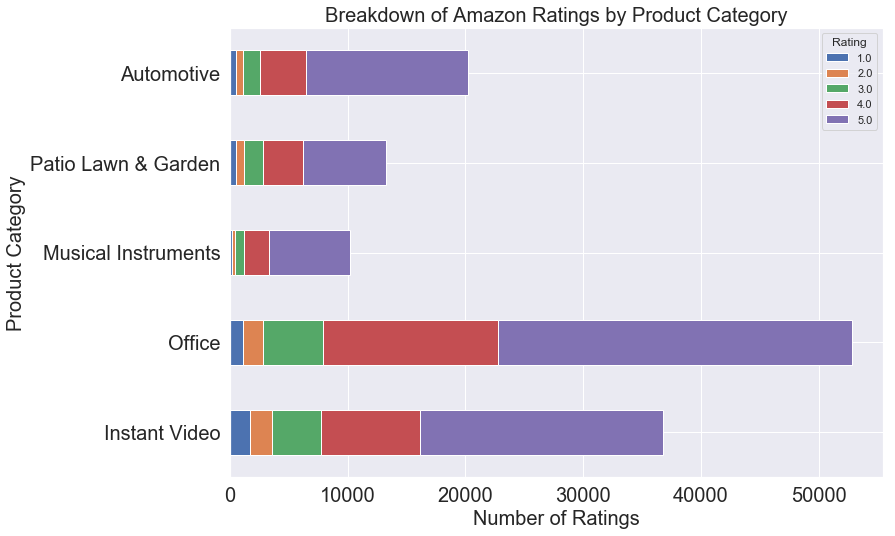

In [214]:
plt.figure(figsize=(15, 15))
fig = plt.figure()

bx1 = df_new.plot( kind='barh', stacked=True, fontsize=20)
    
bx1.set_title("Breakdown of Amazon Ratings by Product Category", fontsize = 20)
bx1.set_xlabel('Number of Ratings', fontsize= 20)
bx1.set_ylabel('Product Category', fontsize=20)
plt.show()

I have used 5 different datasets from Amazon to plot above chart namely 'Automotive', 'Garden and Patio', 'Musical Instruments', 'Office' and 'Instant Video'. These are datasets for different categories of Amazon products. In general, 'Office category'  products and 'Instant Video' seem to be more popular in these 5 categories. In all five categories, number of good ratings is more than number of bad ratings.